[Last-2] Subspace alignment score: 0.0014
[Best-2 overlap] Subspace alignment score: 0.0120
Best-2 eigvec indices: [19, 1732]
Corresponding eigenvalues: [0.000, 0.000]


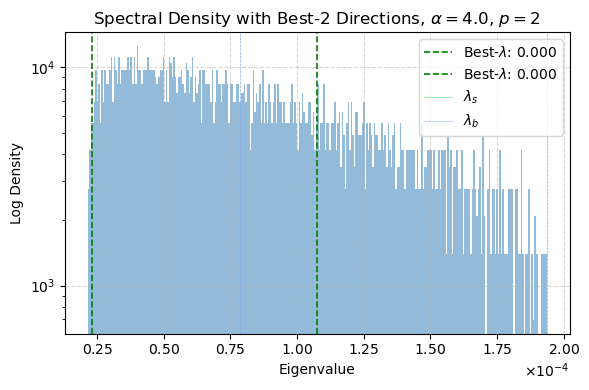

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter
import itertools

# ============ Step 1: 使用近似替代 Bessel 比值 ============
def bessel_ratio_approx(y):
    abs_y = np.abs(y)
    a1, a2 = 0.5, 0.1
    b1, b2 = 0.4, 0.05
    num = 1 + a1 * abs_y + a2 * abs_y**2
    den = 1 + b1 * abs_y + b2 * abs_y**2
    return np.where(den > 1e-6, num / den, 0.0)

from scipy.special import kv as besselk

def compute_T_y_bessel(y_batch):
    abs_y = np.abs(y_batch)
    K1 = besselk(1, abs_y)
    K0 = besselk(0, abs_y)
    with np.errstate(divide='ignore', invalid='ignore'):
        lambda_y = abs_y * (K1 / K0)
        lambda_y[np.isnan(lambda_y)] = 0.0
        lambda_y[np.isinf(lambda_y)] = 0.0

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i], [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)

# ============ Step 2: 构造谱矩阵 ============
def build_T_hat(X, T_y):
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]
        Ti = T_y[i]
        A = np.outer(xi, xi)
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix

# ============ Step 3: 对齐得分函数 ============
def compute_subspace_alignment(U_hat, W_star):
    p = W_star.shape[1]
    score = np.linalg.norm(U_hat.T @ W_star, ord='fro')**2 / p
    return score

# ============ Step 4: 绘图函数 ============
def plot_spectrum_with_best2(eigvals, best2_indices, alpha, p, signal_top=2, lambda_s=None, lambda_b=None, save_path=None):
    bulk_color = '#2878B5'
    signal_color = 'green'

    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=bulk_color, alpha=0.5)

    # 标出最佳两个特征值
    for idx in best2_indices:
        val = eigvals[idx]
        plt.axvline(val, color='green', linestyle='--', linewidth=1.2, label=f'Best-$\\lambda$: {val:.3f}')

    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    plt.yscale('log')
    plt.title(r"Spectral Density with Best-2 Directions, $\alpha = {:.1f}$, $p = {}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# ============ Step 5: 主函数 ============
def main():
    # 参数设置
    d = 1250
    p = 2
    alpha = 4
    n = int(d * alpha)
    np.random.seed(42)

    # Step 1: 信号方向
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)

    # Step 2: 生成数据
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    # Step 3: 构造谱估计器
    T_y = compute_T_y_bessel(y)
    T_hat = build_T_hat(X, T_y)
    eigvals, eigvecs = eigh(T_hat)

    # Step 4: Subspace alignment: max eigvecs（靠后两个）
    top_indices = np.argsort(eigvals)[-p:]
    V_top = eigvecs[:, top_indices]
    U_hat = []
    for i in range(p):
        u = V_top[:, i].reshape(d, p)
        u, _, _ = np.linalg.svd(u, full_matrices=False)
        U_hat.append(u[:, 0])
    U_hat = np.stack(U_hat, axis=1)
    score_max = compute_subspace_alignment(U_hat, W_star)
    print(f"[Last-{p}] Subspace alignment score: {score_max:.4f}")

    # Step 5: 枚举所有组合，找最佳得分
    best_score = -1
    best_pair = None
    for i, j in itertools.combinations(range(2*d), 2):
        V_sel = eigvecs[:, [i, j]]
        U_temp = []
        for k in range(2):
            u = V_sel[:, k].reshape(d, p)
            u, _, _ = np.linalg.svd(u, full_matrices=False)
            U_temp.append(u[:, 0])
        U_temp = np.stack(U_temp, axis=1)
        score = compute_subspace_alignment(U_temp, W_star)
        if score > best_score:
            best_score = score
            best_pair = (i, j)

    print(f"[Best-2 overlap] Subspace alignment score: {best_score:.4f}")
    print(f"Best-2 eigvec indices: {sorted(best_pair)}")
    print(f"Corresponding eigenvalues: [{eigvals[best_pair[0]]:.3f}, {eigvals[best_pair[1]]:.3f}]")

    # Step 6: 绘制谱图并标出 best-2
    lambda_s = eigvals[-1]
    lambda_b = eigvals[d - 1]
    plot_spectrum_with_best2(eigvals=eigvals,
                             best2_indices=best_pair,
                             alpha=alpha,
                             p=p,
                             signal_top=2,
                             lambda_s=lambda_s,
                             lambda_b=lambda_b,
                             save_path=None)

if __name__ == "__main__":
    main()


[Top-2 eigvec] Subspace alignment score: 0.5158
[Best-2 overlap] Subspace alignment score: 0.5118


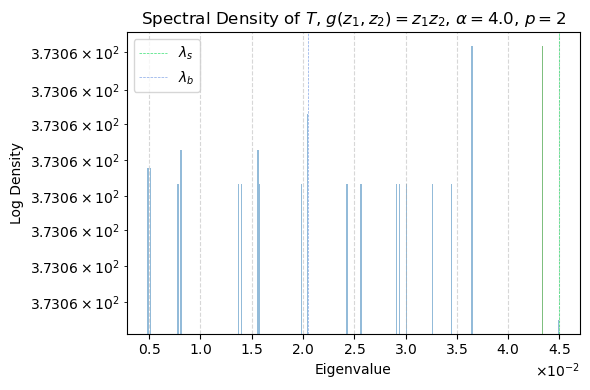

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter


def compute_T_y_bessel(y_batch):
    abs_y = np.abs(y_batch)
    K1 = besselk(1, abs_y)
    K0 = besselk(0, abs_y)
    with np.errstate(divide='ignore', invalid='ignore'):
        lambda_y = abs_y * (K1 / K0)
        lambda_y[np.isnan(lambda_y)] = 0.0
        lambda_y[np.isinf(lambda_y)] = 0.0

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i],
                      [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)  # shape: (n, 2, 2)


def build_T_hat(X, T_y):
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]  # (d,)
        Ti = T_y[i]  # (2,2)
        A = np.outer(xi, xi)  # (d,d)

        # 手动构造 Kronecker 加和
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix


def plot_spectrum(eigvals, alpha, p, signal_top=2, lambda_s=None, lambda_b=None, save_path=None):
    bulk_color = '#2878B5'
    signal_color = 'green'

    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    eigvals_sorted = np.sort(eigvals)
    signal_eigs = eigvals_sorted[-signal_top:]
    signal_bins = set(np.digitize(signal_eigs, bin_edges) - 1)

    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        color = signal_color if i in signal_bins else bulk_color
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=color, alpha=0.5)

    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    plt.yscale('log')
    plt.title(r"Spectral Density of $T$, $g(z_1,z_2) = z_1 z_2$, $\alpha = {:.1f}$, $p = {}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def orthonormalize(A):
    Q, _ = np.linalg.qr(A)
    return Q


def compute_alignment(W_hat, W_star):
    Q1 = orthonormalize(W_hat)
    Q2 = orthonormalize(W_star)
    overlap = Q1.T @ Q2
    u, s, _ = np.linalg.svd(overlap)
    return np.mean(s)


def main():
    # 参数设置
    d =10
    p = 2
    alpha = 4
    n = int(d * alpha)
    np.random.seed(42)

    # Step 1-4: 生成数据
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    z1, z2 = Z[:, 0], Z[:, 1]
    y = z1 * z2

    # Step 5-6: 构造 T(y) 和 T_hat
    T_y = compute_T_y_bessel(y)
    T_hat = build_T_hat(X, T_y)

    # Step 7: 特征分解
    eigvals, eigvecs = eigh(T_hat)

    # Step 8-1: 原始 top-p 对齐
    top_vectors = eigvecs[:, -p:]  # shape: (2d, p)
    W_hat = np.zeros((d, p))
    for j in range(p):
        W_hat[:, j] = top_vectors[j * d:(j + 1) * d, j]
    alignment_score = compute_alignment(W_hat, W_star)
    print(f"[Top-{p} eigvec] Subspace alignment score: {alignment_score:.4f}")

    # Step 8-2: 全体中选出 overlap 最大的 p 个
    overlaps = []
    for i in range(2 * d):
        vec = eigvecs[:, i]
        v1 = vec[:d]
        overlap_score = np.sum((W_star.T @ v1) ** 2)
        overlaps.append((i, overlap_score))
    overlaps.sort(key=lambda x: x[1], reverse=True)

    # 构造最佳组合 W_hat_best
    best_indices = [idx for idx, _ in overlaps[:p]]
    W_hat_best = np.zeros((d, p))
    for j, idx in enumerate(best_indices):
        W_hat_best[:, j] = eigvecs[:d, idx]
    improved_score = compute_alignment(W_hat_best, W_star)
    print(f"[Best-{p} overlap] Subspace alignment score: {improved_score:.4f}")

    # Step 9: 绘图
    lambda_s = eigvals[-1]
    lambda_b = eigvals[d - 1]
    plot_spectrum(eigvals, alpha=alpha, p=p, lambda_s=lambda_s, lambda_b=lambda_b)


if __name__ == "__main__":
    main()


[Last-2] Subspace alignment score: 0.0108
[Best-2 overlap] Subspace alignment score: 0.0469
Best-2 eigvec indices: [111, 236]
Corresponding eigenvalues: [0.000, 0.001]


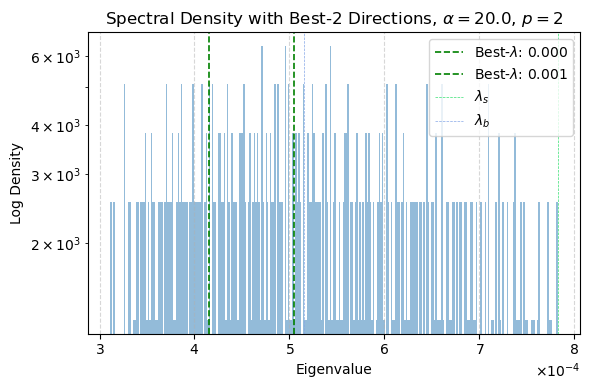

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter
import itertools

# ============ Step 1: 使用近似替代 Bessel 比值 ============
def bessel_ratio_approx(y):
    abs_y = np.abs(y)
    a1, a2 = 0.5, 0.1
    b1, b2 = 0.4, 0.05
    num = 1 + a1 * abs_y + a2 * abs_y**2
    den = 1 + b1 * abs_y + b2 * abs_y**2
    return np.where(den > 1e-6, num / den, 0.0)

from scipy.special import kv as besselk

def compute_T_y_bessel(y_batch):
    abs_y = np.abs(y_batch)
    K1 = besselk(1, abs_y)
    K0 = besselk(0, abs_y)
    with np.errstate(divide='ignore', invalid='ignore'):
        lambda_y = abs_y * (K1 / K0)
        lambda_y[np.isnan(lambda_y)] = 0.0
        lambda_y[np.isinf(lambda_y)] = 0.0

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i], [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)

# ============ Step 2: 构造谱矩阵 ============
def build_T_hat(X, T_y):
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]
        Ti = T_y[i]
        A = np.outer(xi, xi)
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix

# ============ Step 3: 对齐得分函数 ============
def compute_subspace_alignment(U_hat, W_star):
    p = W_star.shape[1]
    score = np.linalg.norm(U_hat.T @ W_star, ord='fro')**2 / p
    return score

# ============ Step 4: 绘图函数 ============
def plot_spectrum_with_best2(eigvals, best2_indices, alpha, p, signal_top=2, lambda_s=None, lambda_b=None, save_path=None):
    bulk_color = '#2878B5'
    signal_color = 'green'

    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=bulk_color, alpha=0.5)

    # 标出最佳两个特征值
    for idx in best2_indices:
        val = eigvals[idx]
        plt.axvline(val, color='green', linestyle='--', linewidth=1.2, label=f'Best-$\\lambda$: {val:.3f}')

    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    plt.yscale('log')
    plt.title(r"Spectral Density with Best-2 Directions, $\alpha = {:.1f}$, $p = {}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# ============ Step 5: 主函数 ============
def main():
    # 参数设置
    d = 250
    p = 2
    alpha = 20
    n = int(d * alpha)
    np.random.seed(42)

    # Step 1: 信号方向
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)

    # Step 2: 生成数据
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    # Step 3: 构造谱估计器
    T_y = compute_T_y_bessel(y)
    T_hat = build_T_hat(X, T_y)
    eigvals, eigvecs = eigh(T_hat)

    # Step 4: Subspace alignment: max eigvecs（靠后两个）
    top_indices = np.argsort(eigvals)[-p:]
    V_top = eigvecs[:, top_indices]
    U_hat = []
    for i in range(p):
        u = V_top[:, i].reshape(d, p)
        u, _, _ = np.linalg.svd(u, full_matrices=False)
        U_hat.append(u[:, 0])
    U_hat = np.stack(U_hat, axis=1)
    score_max = compute_subspace_alignment(U_hat, W_star)
    print(f"[Last-{p}] Subspace alignment score: {score_max:.4f}")

    # Step 5: 枚举所有组合，找最佳得分
    best_score = -1
    best_pair = None
    for i, j in itertools.combinations(range(2*d), 2):
        V_sel = eigvecs[:, [i, j]]
        U_temp = []
        for k in range(2):
            u = V_sel[:, k].reshape(d, p)
            u, _, _ = np.linalg.svd(u, full_matrices=False)
            U_temp.append(u[:, 0])
        U_temp = np.stack(U_temp, axis=1)
        score = compute_subspace_alignment(U_temp, W_star)
        if score > best_score:
            best_score = score
            best_pair = (i, j)

    print(f"[Best-2 overlap] Subspace alignment score: {best_score:.4f}")
    print(f"Best-2 eigvec indices: {sorted(best_pair)}")
    print(f"Corresponding eigenvalues: [{eigvals[best_pair[0]]:.3f}, {eigvals[best_pair[1]]:.3f}]")

    # Step 6: 绘制谱图并标出 best-2
    lambda_s = eigvals[-1]
    lambda_b = eigvals[d - 1]
    plot_spectrum_with_best2(eigvals=eigvals,
                             best2_indices=best_pair,
                             alpha=alpha,
                             p=p,
                             signal_top=2,
                             lambda_s=lambda_s,
                             lambda_b=lambda_b,
                             save_path=None)

if __name__ == "__main__":
    main()


[Top-2 eigvec] Subspace alignment score: 0.0950
[Best-2 overlap - corrected] Subspace alignment score: 0.1148


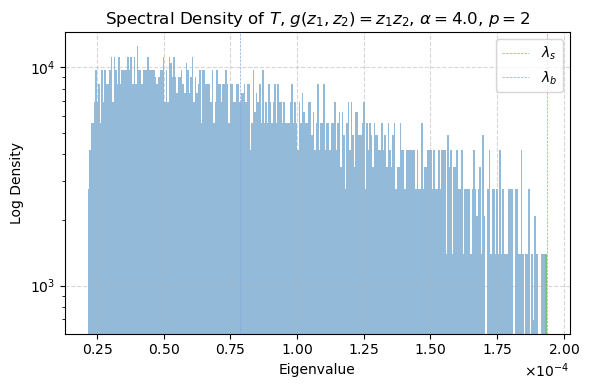

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter
import warnings


def compute_T_y_bessel(y_batch):
    abs_y = np.abs(y_batch)
    K1 = besselk(1, abs_y)
    K0 = besselk(0, abs_y)
    with np.errstate(divide='ignore', invalid='ignore'):
        lambda_y = abs_y * (K1 / K0)
        lambda_y[np.isnan(lambda_y)] = 0.0
        lambda_y[np.isinf(lambda_y)] = 0.0

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i],
                      [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)  # shape: (n, 2, 2)


def build_T_hat(X, T_y):
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]  # (d,)
        Ti = T_y[i]  # (2,2)
        A = np.outer(xi, xi)  # (d,d)

        # 手动构造 Kronecker 加和
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix


def plot_spectrum(eigvals, alpha, p, signal_top=2, lambda_s=None, lambda_b=None, save_path=None):
    bulk_color = '#2878B5'
    signal_color = 'green'

    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    eigvals_sorted = np.sort(eigvals)
    signal_eigs = eigvals_sorted[-signal_top:]
    signal_bins = set(np.digitize(signal_eigs, bin_edges) - 1)

    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        color = signal_color if i in signal_bins else bulk_color
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=color, alpha=0.5)

    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    plt.yscale('log')
    plt.title(r"Spectral Density of $T$, $g(z_1,z_2) = z_1 z_2$, $\alpha = {:.1f}$, $p = {}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def orthonormalize(A):
    Q, _ = np.linalg.qr(A)
    return Q


def compute_alignment(W_hat, W_star):
    Q1 = orthonormalize(W_hat)
    Q2 = orthonormalize(W_star)
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)


def generalized_overlap_corrected_symmetric(W_star, eigvecs, d, p, top_k=None):
    """
    对称谱估计器的 overlap-corrected 子空间对齐指标，标准化为 [0,1]
    """
    if top_k is None:
        top_k = p

    overlaps = []
    for i in range(2 * d):
        vec = eigvecs[:, i]
        v_proj = vec[:d]  # 只取第一段 d 维
        overlap_score = np.sum((W_star.T @ v_proj) ** 2)
        overlaps.append((i, overlap_score))

    overlaps.sort(key=lambda x: x[1], reverse=True)
    best_indices = [idx for idx, _ in overlaps[:top_k]]

    W_hat_best = np.zeros((d, top_k))
    for j, idx in enumerate(best_indices):
        W_hat_best[:, j] = eigvecs[:d, idx]

    Q1 = orthonormalize(W_hat_best)
    Q2 = orthonormalize(W_star)
    _, s, _ = np.linalg.svd(Q1.T @ Q2)
    score = np.mean(s)

    return score, overlaps[:top_k]


def main():
    # 参数设置
    d = 1250
    p = 2
    alpha = 4
    n = int(d * alpha)
    np.random.seed(42)

    # Step 1-4: 生成数据
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    z1, z2 = Z[:, 0], Z[:, 1]
    y = z1 * z2

    # Step 5-6: 构造 T(y) 和 T_hat
    T_y = compute_T_y_bessel(y)
    T_hat = build_T_hat(X, T_y)

    # Step 7: 特征分解
    eigvals, eigvecs = eigh(T_hat)

    # Step 8-1: 原始 top-p 对齐
    top_vectors = eigvecs[:, -p:]  # shape: (2d, p)
    W_hat = np.zeros((d, p))
    for j in range(p):
        W_hat[:, j] = top_vectors[j * d:(j + 1) * d, j]
    alignment_score = compute_alignment(W_hat, W_star)
    print(f"[Top-{p} eigvec] Subspace alignment score: {alignment_score:.4f}")

    # Step 8-2: best-overlap 策略（非对称评估适配）
    corrected_score, top_overlaps = generalized_overlap_corrected_symmetric(W_star, eigvecs, d, p)
    print(f"[Best-{p} overlap - corrected] Subspace alignment score: {corrected_score:.4f}")

    # Step 9: 绘图
    lambda_s = eigvals[-1]
    lambda_b = eigvals[d - 1]
    plot_spectrum(eigvals, alpha=alpha, p=p, lambda_s=lambda_s, lambda_b=lambda_b)


if __name__ == "__main__":
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        main()


In [29]:
import numpy as np
from scipy.linalg import eigh, qr
from scipy.special import kv as besselk
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt



# ===================================
# Step 1: 构造 ground truth 子空间
# ===================================
def generate_ground_truth(d=100, p=2):
    W = np.random.randn(d, p)
    W, _ = np.linalg.qr(W)  # 正交化
    return W

# ===================================
# Step 2: 构造数据 (x, y)
# ===================================
def generate_data(W_star, n):
    d, p = W_star.shape
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star  # shape (n, p)
    y = Z[:, 0] * Z[:, 1]  # link function: g(z) = z1 * z2
    return X, y

# ===================================
# Step 3: 计算 Bessel-based T(y)
# ===================================
def compute_T_y_bessel(y_batch):
    abs_y = np.abs(y_batch)
    K1 = besselk(1, abs_y)
    K0 = besselk(0, abs_y)
    with np.errstate(divide='ignore', invalid='ignore'):
        lambda_y = abs_y * (K1 / K0)
        lambda_y[np.isnan(lambda_y)] = 0.0
        lambda_y[np.isinf(lambda_y)] = 0.0

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i],
                      [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)  # shape: (n, 2, 2)

# ===================================
# Step 4: 构造对称谱估计器矩阵 T_hat
# ===================================
def build_T_hat(X, T_y):
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]
        Ti = T_y[i]
        A = np.outer(xi, xi)
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix

# ===================================
# Step 5: 从特征向量中提取估计子空间
# ===================================
def extract_W_hat_from_T(T_hat, p, d):
    eigvals, eigvecs = eigh(T_hat)  # 升序
    W_hat = np.zeros((d, p))
    for j in range(p):
        v = eigvecs[:, -(j + 1)]  # 最大特征值对应向量
        W_hat[:, j] = v[:d]  # 只取前 d 维
    return W_hat, eigvals

# ===================================
# Step 6: 子空间对齐度评估函数
# ===================================
def compute_alignment(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# ===================================
# 主函数：统一流程执行
# ===================================
def main():
    alpha = 4     # 数据维度
    p = 2        # 子空间维度
    n = 5000    # 样本量
    d = int(n / alpha)

    # 构造真实信号子空间与样本
    W_star = generate_ground_truth(d, p)
    X, y = generate_data(W_star, n)

    # 构造对称谱估计器矩阵
    T_y = compute_T_y_bessel(y)
    T_hat = build_T_hat(X, T_y)

    # 提取子空间与评估得分
    W_hat, eigvals = extract_W_hat_from_T(T_hat, p, d)
    score = compute_alignment(W_hat, W_star)

    print(f"[Symmetric Spectral Estimator] Subspace alignment score: {score:.4f}")

if __name__ == "__main__":
    main()


[Symmetric Spectral Estimator] Subspace alignment score: 0.0640


In [33]:
# ===================================
# Step 6-Alt: generalized overlap for Symmetric Estimator
# ===================================
def compute_generalized_overlap_symmetric(W_hat, X, W_star):
    """
    统一评估标准：将对称谱估计器中得到的 W_hat（d×p）
    应用于原始 X 得到估计信号投影，再与真实投影 Z_star 比较
    """
    Z_hat = X @ W_hat             # shape: (n, p)
    Z_star = X @ W_star           # shape: (n, p)

    # 构造 V_hat ∈ ℝ^{n × 2p}
    V_hat = np.stack([Z_hat, Z_star], axis=-1)  # shape: (n, p, 2)
    V_hat = V_hat.transpose(0, 2, 1).reshape(X.shape[0], 2 * W_hat.shape[1])  # shape: (n, 2p)

    # 与 Z_star 做比较（用 QR+SVD 计算）
    Q1, _ = np.linalg.qr(V_hat)
    Q2, _ = np.linalg.qr(Z_star)
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    score = np.mean(s)
    return score
score = compute_generalized_overlap_symmetric(W_hat, X, W_star)
print(f"[Symmetric Spectral Estimator — Generalized Overlap] Subspace alignment score: {score:.4f}")


NameError: name 'W_hat' is not defined